In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import pearsonr

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.mvpa import decode_subject_atlas_rois
from dd_kable_analysis.tseries_model.design_matrix import make_design_matrix
from dd_kable_analysis.tseries_model.tseries_model_qa import make_design_qa_figure


# What is this?

## Make a single ROI file for the analysis
My code works best if the ROIs are in a single 3D nifti (each ROI is an integer), so I make that here for the ROIs that Josh originally gave me.  Then I tested the `decode_subject_atlas_rois()` function using it.

There's an image below displaying the ROI set.

## Double check how many subjects to expect
The code automatically filters out the high VIF trials and then checks that there are enough trials per run (at least 20) and enough runs (at least 3 to allow for double CV, leave one run out for each level of CV).

There should be 111 subjects, total.  Most have 4 runs (>80 subjects) and some have 3 (~30 subjects, barplot below).

In [2]:
from nilearn import datasets

cfg = load_config()
sch = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
df = decode_subject_atlas_rois(cfg, 'dmp0330', atlas_img=sch.maps, verbose=True)
print(df.shape)

[fetch_atlas_schaefer_2018] Dataset found in /home/users/jmumford/nilearn_data/schaefer_2018
[dmp0330] QA-passed runs: ['1', '2', '3']
[dmp0330] trial regressors in design (pre-filter): 87
[dmp0330] omitted high-VIF trials: 1
[dmp0330] missing beta files: 0
[dmp0330] kept trials (post-filter): 86
[dmp0330] kept by run: {'1': 28, '2': 29, '3': 29}
[dmp0330] runs with >= 20 kept trials: ['1', '2', '3']
[global] X_all=(86, 240143) (mask vox=240143) y=(86,) groups=(86,)
[global] trials per run:
 1    28
2    29
3    29
[NiftiMasker.wrapped] Resampling images


/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/.venv/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[roi map] n_rois=200
[roi map] voxels per ROI percentiles: [ 345.    448.95  674.   1350.   6242.  ]
(200, 11)


### Masks
Note:  OFCmed should correspond roughly to VMPFC

L_Caudate_mask.nii.gz

OFCmed_R_mask.nii.gz

R_Caudate_mask.nii.gz

L_NACC_mask.nii.gz

Precentral_L_mask.nii.gz 

R_NACC_mask.nii.gz

OFCmed_L_mask.nii.gz 

Precentral_R_mask.nii.gz

Below I create and single 3D file that has all of these ROIs in it so I can use that with my scripts.

In [3]:
cfg = load_config()


mask_dir = cfg.masks_dir

mask_files = [
    'L_Caudate_mask.nii.gz',
    'R_Caudate_mask.nii.gz',
    'L_NACC_mask.nii.gz',
    'R_NACC_mask.nii.gz',
    'Precentral_L_mask.nii.gz',
    'Precentral_R_mask.nii.gz',
    'OFCmed_L_mask.nii.gz',
    'OFCmed_R_mask.nii.gz',
]

out_nii = mask_dir / 'josh_orig_rois.nii.gz'
out_txt = mask_dir / 'josh_orig_rois_labels.txt'
overlap_txt = mask_dir / 'josh_orig_rois_overlaps.txt'

# Load masks
imgs = [nib.load(str(mask_dir / f)) for f in mask_files]

# Sanity: require same grid
ref = imgs[0]
ref_shape = ref.shape[:3]
ref_aff = ref.affine
for f, img in zip(mask_files, imgs):
    if img.shape[:3] != ref_shape or not np.allclose(img.affine, ref_aff):
        raise ValueError(f'Mask {f} is not on the same grid as the first mask.')

# Build labeled volume
label_data = np.zeros(ref_shape, dtype=np.int16)
overlap_counts = np.zeros(ref_shape, dtype=np.int16)

label_lines = ['# label\troi_name\tmask_file\n']

for lab, (f, img) in enumerate(zip(mask_files, imgs), start=1):
    data = img.get_fdata()
    m = data > 0  # treat any positive value as in-mask

    # track overlap with already-labeled voxels
    overlap = m & (label_data != 0)
    n_overlap = int(overlap.sum())

    # assign label only where currently unlabeled
    label_data[m & (label_data == 0)] = lab

    # for reporting: count how many masks include each voxel
    overlap_counts[m] += 1

    roi_name = f.replace('_mask.nii.gz', '')
    label_lines.append(f'{lab}\t{roi_name}\t{f}\n')
    print(f'[{lab}] {roi_name}: vox={int(m.sum())} overlap_with_previous={n_overlap}')


[1] L_Caudate: vox=805 overlap_with_previous=0
[2] R_Caudate: vox=861 overlap_with_previous=0
[3] L_NACC: vox=163 overlap_with_previous=0
[4] R_NACC: vox=143 overlap_with_previous=0
[5] Precentral_L: vox=3526 overlap_with_previous=0
[6] Precentral_R: vox=3381 overlap_with_previous=0
[7] OFCmed_L: vox=550 overlap_with_previous=0
[8] OFCmed_R: vox=621 overlap_with_previous=0


In [4]:
# Summarize overlaps
n_any_overlap = int((overlap_counts > 1).sum())
max_overlap = int(overlap_counts.max())
overlap_report = []
overlap_report.append(f'Any-overlap voxels (belonging to >1 mask): {n_any_overlap}\n')
overlap_report.append(f'Max overlap count in any voxel: {max_overlap}\n')

# If you want, list pairwise overlaps too
overlap_report.append('\nPairwise overlaps (voxels):\n')
mask_bools = [(img.get_fdata() > 0) for img in imgs]
for i in range(len(mask_files)):
    for j in range(i + 1, len(mask_files)):
        nij = int(np.logical_and(mask_bools[i], mask_bools[j]).sum())
        if nij > 0:
            overlap_report.append(f'{mask_files[i]}  ∩  {mask_files[j]}: {nij}\n')


In [5]:
overlap_report

['Any-overlap voxels (belonging to >1 mask): 0\n',
 'Max overlap count in any voxel: 1\n',
 '\nPairwise overlaps (voxels):\n']

In [6]:
# Save outputs
out_img = nib.Nifti1Image(label_data, ref_aff, ref.header)
out_img.set_data_dtype(np.int16)
out_img.to_filename(out_nii)

out_txt.write_text(''.join(label_lines))

print('Wrote:', out_nii)
print('Wrote:', out_txt)


Wrote: /oak/stanford/groups/russpold/users/buckholtz/DD_Kable/derivatives/masks/josh_orig_rois.nii.gz
Wrote: /oak/stanford/groups/russpold/users/buckholtz/DD_Kable/derivatives/masks/josh_orig_rois_labels.txt


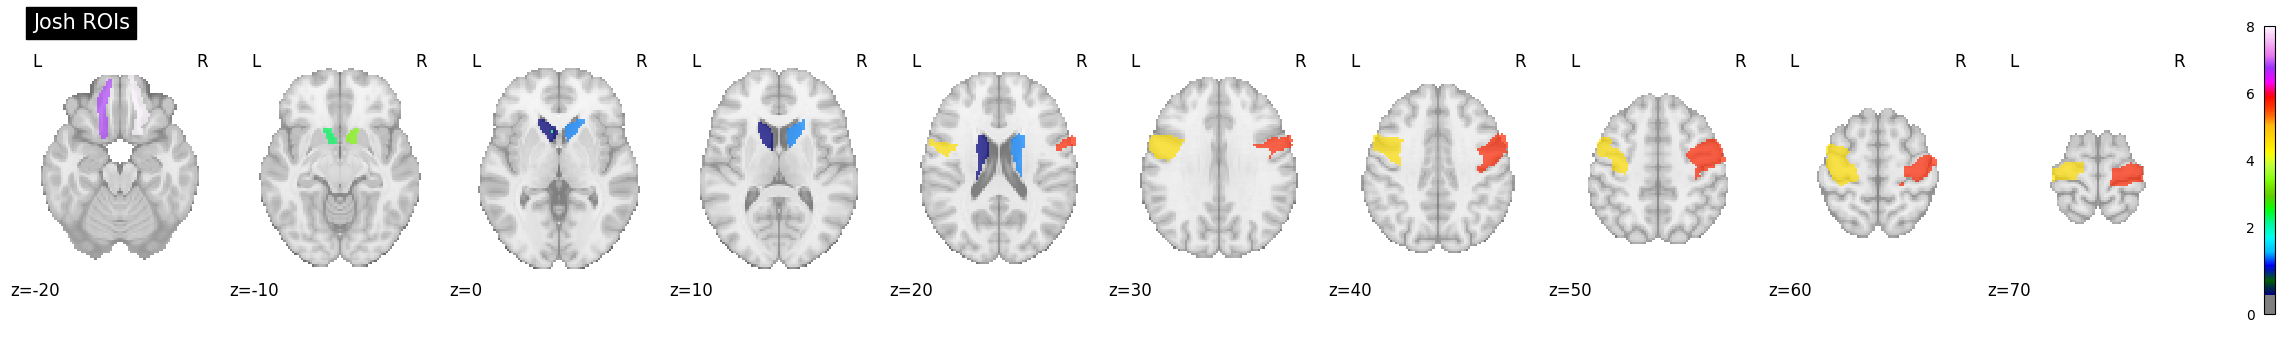

In [7]:
# look at image of ROIs
from nilearn.plotting import plot_roi

z_coord = np.arange(-20, 71, 10)
plot_roi(
    out_img,
    display_mode='z',
    cut_coords=z_coord,
    title='Josh ROIs',
)
plt.show()


In [8]:
df = decode_subject_atlas_rois(cfg, 'dmp0330', atlas_img=out_img, verbose=True)


[dmp0330] QA-passed runs: ['1', '2', '3']


[dmp0330] trial regressors in design (pre-filter): 87
[dmp0330] omitted high-VIF trials: 1
[dmp0330] missing beta files: 0
[dmp0330] kept trials (post-filter): 86
[dmp0330] kept by run: {'1': 28, '2': 29, '3': 29}
[dmp0330] runs with >= 20 kept trials: ['1', '2', '3']
[global] X_all=(86, 240143) (mask vox=240143) y=(86,) groups=(86,)
[global] trials per run:
 1    28
2    29
3    29
[NiftiMasker.wrapped] Resampling images


/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/.venv/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)
/oak/stanford/groups/russpold/users/buckholtz/DD_Kable/scripts/dd-kable-analysis/.venv/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)


[roi map] n_rois=8
[roi map] voxels per ROI percentiles: [ 329.    400.05 1111.   2834.3  3017.  ]


In [9]:
df

,sub_id,roi_label,n_trials,n_runs,n_vox_preQC,n_vox_postQC,r,r2_cv,fisher_z,rmse,mean_alpha
0,dmp0330,1,86,3,2383,2327,0.078681,0.007108,0.078844,19.208514,342846.326838
1,dmp0330,2,86,3,1355,1307,0.263190,0.048493,0.269532,18.803931,4600.100862
2,dmp0330,3,86,3,532,505,0.130098,0.016171,0.130839,19.120641,4600.100862
3,dmp0330,4,86,3,867,842,-0.029798,-0.019576,-0.029807,19.464918,340606.739568
4,dmp0330,5,86,3,3017,3004,0.021987,-0.017454,0.021990,19.444650,352510.766418
5,dmp0330,6,86,3,2495,2477,0.145391,0.020075,0.146429,19.082666,26074.560021
6,dmp0330,7,86,3,573,541,0.151136,0.017351,0.152303,19.109174,4600.100862
7,dmp0330,8,86,3,329,237,0.042300,-0.002313,0.042325,19.299423,334701.729778


## Checking how many subjects we should expect

They need at least 3 runs

In [10]:
subjects = cfg.subject_lists / 'mvpa_subject_list.txt'


In [11]:
from dd_kable_analysis.mvpa import build_subject_behav_bold_df

all_behav_bold_dfs = []
n_good_runs = []

for sub_id in subjects.read_text().splitlines():
    try:
        test = build_subject_behav_bold_df(cfg, sub_id, verbose=False)
        df_loop = test.behav_bold_df
        df_loop['sub_id'] = sub_id
        all_behav_bold_dfs.append(df_loop)
        n_good_runs.append(len(test.good_runs))
    except Exception as e:
        print(f'Error processing subject {sub_id}: {e}')

Error processing subject dmp0063: ❌ 16 trials for sub dmp0063, run 2 are clipped. Cannot generate design matrix.
Error processing subject dmp0148: [dmp0148] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp0492: [dmp0492] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp0521: [dmp0521] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp0587: [dmp0587] has only 1 QA-passed runs; requires >= 3.
Error processing subject dmp0678: [dmp0678] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp0844: [dmp0844] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp1000: [dmp1000] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp1037: [dmp1037] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp1064: [dmp1064] has only 2 QA-passed runs; requires >= 3.
Error processing subject dmp1135: [dmp1135] has only 1 QA-passed runs; requires >= 3.
Error processing subject dm

In [12]:
all_behav_bold_df = pd.concat(all_behav_bold_dfs, ignore_index=True)
print(all_behav_bold_df.shape)

(11976, 12)


Subjects: 111
Runs per subject:


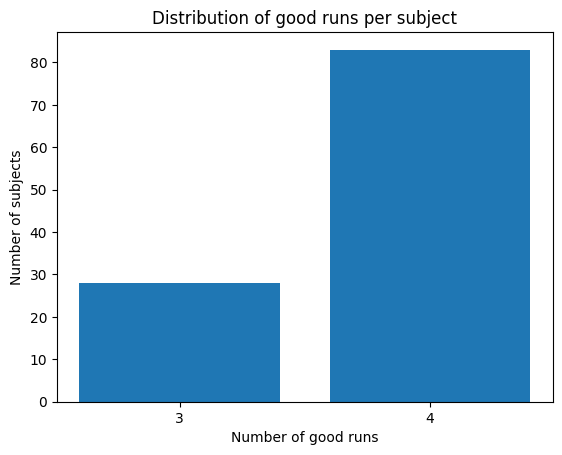

In [13]:
# Double check number of subjects and runs per subject
print('Subjects:', all_behav_bold_df['sub_id'].nunique())
print('Runs per subject:')
runs_per_sub = all_behav_bold_df.groupby('sub_id')['run'].nunique()
num_runs, num_run_counts = np.unique(runs_per_sub, return_counts=True)
plt.bar(num_runs, num_run_counts)
plt.xticks(num_runs)
plt.xlabel('Number of good runs')
plt.ylabel('Number of subjects')
plt.title('Distribution of good runs per subject')
plt.show()